In [1]:
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt

In [2]:
#read in data file and skip to data
file=open("/Users/Roslyn/Desktop/run-XXXII", "r")

In [3]:
with file as f:
    lines_after_6 = f.readlines()[7:]

In [4]:
#extract first two coloumns and convert to float
col1=[]
for x in lines_after_6:
    col1.append(float(x.split()[0]))
        
col2=[]
for x in lines_after_6:
    col2.append(float(x.split()[1]))
    
#combine real and imaginary parts to give list of complex data outputs
data=np.vectorize(complex)(col1, col2)

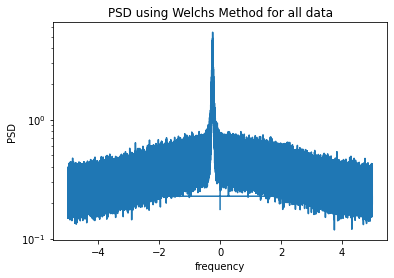

In [5]:
#Find and plot PSD 
fall, Pxx_all = signal.welch(data-np.mean(data), 10, nperseg=1000000, return_onesided=False)
plt.semilogy(fall, Pxx_all)
plt.title('PSD using Welchs Method for all data')
plt.xlabel('frequency')
plt.ylabel('PSD')
plt.show()

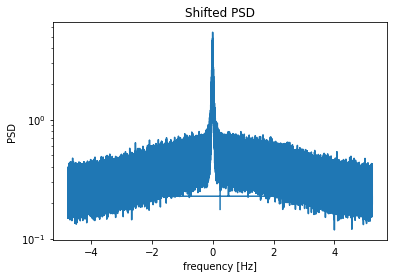

In [6]:
#shift the peak to zero before putting into calibration eqs
maxindex=np.argmax(Pxx_all)
shift=fall[maxindex]
fallshift=fall+abs(shift)

plt.semilogy(fallshift, Pxx_all)
plt.title('Shifted PSD')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

In [7]:
#displacement noise equation from GW Summary 
#Su(omega) =(1/k i omega)^2 * 1/Z^2 * Sv(omega)
#(1/i)^2 = -1
#omega=2pi f

#SQUID transimpedance 
Zsquid= 1.2e6

#spectral density of voltage noise output by SQUID - convert Sv(f) to Sv(omega)=Sv here
Sv= [x*(1/2*np.pi) for x in Pxx_all]

#electromechanical coupling constant
ksquared= 1e-5

#omega frequency axis, add mode freq and convert from Hz to rad/s, and create squared axis 
omega= [(x+5.505e6)*(2*np.pi) for x in fallshift]
omegasq= [x**2 for x in omega]

#multiply 1/omega^2 list and Sv 
product= [(1/a) * b for a, b in zip(omegasq, Sv)]
 
#put into equation for Su(omega)
#note: 1/i^2 makes constants negative
constants = -(1/ksquared)*(1/(Zsquid**2))
Su = [x*(constants) for x in product]

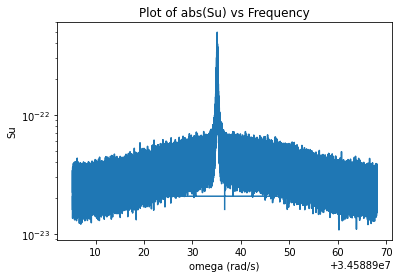

In [8]:
#plot of Su(omega) vs omega
absSu = [abs(x) for x in Su]

plt.semilogy(omega, absSu)
plt.title('Plot of abs(Su) vs Frequency')
plt.xlabel('omega (rad/s)')
plt.ylabel('Su')
plt.show()

In [9]:
#transfer function equation
#H(iomega)= - (xi*ho*omega^2/2) / (iomega)^2 + tau^-1*omega + omega_n^2
#xi = 8/n*pi Erf(sqrt(n)*eta_x)Erf(sqrt(n)*eta_y) / Erf(sqrt(2n)*eta_x)Erf(sqrt(2n)*eta_y)
from scipy import special

eta_x = eta_y = 10
ho = 2.5e-4
tau = 3
n = 3
modeomega= 2*np.pi*5.505e6

xi= (8/n*np.pi)*((special.erf(n**(1/2)*eta_x)*special.erf(n**(1/2)*eta_y))/(special.erf((2*n)**(1/2)*eta_x)*special.erf((2*n)**(1/2)*eta_y)))
omegasqover2 = [x/2 for x in omegasq]
Hnumerator= [x*(-xi*ho) for x in omegasqover2]

iomegasq= [-x for x in omegasq]
invtauomega= [x*(tau**(-1)) for x in omega]
addition = [a+b for a,b in zip(iomegasq, invtauomega)]
Hdenom= [x+((modeomega)**2) for x in addition]

H= [a/b for a,b in zip(Hnumerator, Hdenom)]

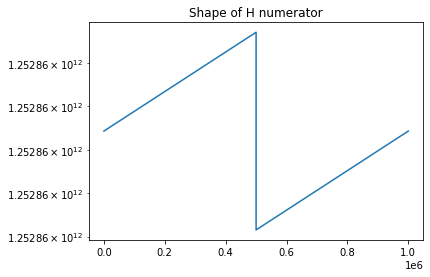

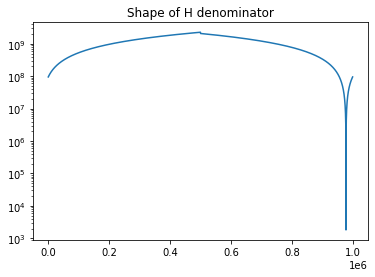

In [10]:
#Take abs values to plot shape of H components 
absHnum= [abs(x) for x in Hnumerator]
absHdenom= [abs(x) for x in Hdenom]
absH= [abs(x) for x in H]

plt.semilogy(absHnum)
plt.title('Shape of H numerator')
plt.show()

plt.semilogy(absHdenom)
plt.title('Shape of H denominator')
plt.show()


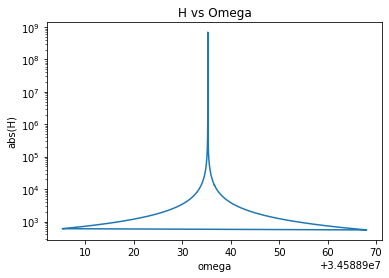

In [11]:
plt.semilogy(omega, absH)
plt.title('H vs Omega')
plt.xlabel('omega')
plt.ylabel('abs(H)')
plt.show()


In [12]:
#square root of Su values
import cmath 
Snumerator= [cmath.sqrt(x) for x in Su]

#equation denominator is absolute value of H(iomega)
Sdenom = [abs(x) for x in H]

S= [a/b for a,b in zip(Snumerator, Sdenom)]

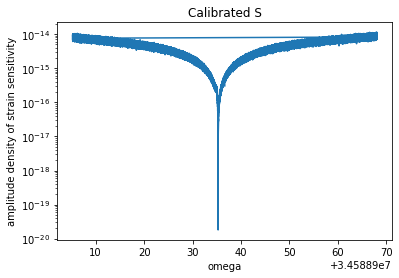

In [13]:
#take abs value for plotting
Sabs= [abs(x) for x in S]

plt.semilogy(omega, Sabs)
plt.title('Calibrated S')
plt.xlabel('omega')
plt.ylabel('amplitude density of strain sensitivity')
#plt.xlim(-0.3,-0.2)
plt.show()